# Predicting House Values using Tensorflow

In this notebook, we will consider a simple idea of trying to predict the median house value within a district.
In order to achieve this we will be using a simple method just based on the median income of a household (a group of people residing within a home). 

The approach is as follows:
* We take the data of median house values from some source (in our case we use a standard dataset from California).
* We will be considering the median house value from the data based on the median income of a household.
* We will then fit a line which best correlates the house value with the income.
* We will plot and consider the difference.

As is apparent, just basing the house value on the income is a simplification. However, this simple model
can be improved by considering  other features such as closeness to the sea or other aspects that influence the
house price.

In this notebook we will be carrying out this exercise using the Tensorflow package. In the next notebook, we will be doing
the same using another package, viz., PyTorch. These two are the most popular AI packages that are used by Google and Facebook
for all the AI related works and is used by hundreds of companies. This exercise takes you through the fundamental linear regression model from a number of different angles. First we consider an analytic analysis and then we continue to consider how to solve the same problem using numerical methods. This lab also serves and an introduction to the Tensorflow toolkit which will be useful for a variety of machine learning tasks in the future and is used by Google to solve massive machine learning problems on their clusters.

The fitting of a line to data is termed `linear regression'. We will be studying this and other similar algorithms in detail in the later modules of the
course.


In [2]:
# import relevant third-party libraries
import numpy as np 

# tensorflow package is not included in Anaconda by default, you may want to run the notebook file on Google Colab (https://colab.research.google.com/)
import tensorflow as tf

from sklearn import datasets as ds

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# load california housing data
california = ds.fetch_california_housing()

# extract attribute (median income of a household) and target (median house value)
x_raw = california.data[:,california.feature_names.index('MedInc')]
y_raw = california.target

## California Housing Dataset
A description of the dataset used is provided here.

Data Set Characteristics:  
    :Number of Instances: 20640 

    :Number of Attributes: 8 numeric, predictive attributes
    
    :Target Variable: the median house value for California districts, in hundreds of thousands of dollars ($100,000)

    :Attribute Information (in order):
        - MedInc     median income in block group
        - HouseAge       median house age in block group
        - AveRooms    average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population      block group population
        - AveOccup       average number of household members
        - Latitude      block group latitude
        - Longitude      block group longitude

    :Missing Attribute Values: None


The dataset was taken from the StatLib repository (maintained at Carnegie Mellon University):
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html 

It was derived from the 1990 U.S. census, using one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people) [1].

The California Housing data has been used in many machine learning papers that address regression problems, such as [2].
     
### References

   
   - [1] https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset
   - [2] Pace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions, Statistics and Probability Letters, 33 (1997) 291-297

## Preparing the data

We are going to look at the relationship between the "median income in block group" and median house value in the California Housing dataset. First let us partition the data into a training and test split. We are going for 60% training and 40% testing.

In [4]:
total_count = x_raw.shape[0]

# shuffle the data to avoid any ordering bias..
np.random.seed(0)
shuffle = np.random.permutation(total_count)

x = x_raw[shuffle]
y = y_raw[shuffle]

# split the data into training set (to train the ML model) and testing set (to test the performance of the trained model)

split = int(total_count * 0.6)

x_train_unnormalised = x[:split]
y_train_unnormalised = y[:split]

x_test_unnormalised = x[split:]
y_test_unnormalised = y[split:]

print('Training set size:', x_train_unnormalised.shape[0])
print('Test set size:', x_test_unnormalised.shape[0])

Training set size: 12384
Test set size: 8256


## Data Visualisation

To allow for easy visualisation as you progress through the task we are using a single dimensional data set. Both the input $x$ and output $y$ are scalars so we can plot them on a standard scatter plot.

Text(0.5, 1.0, 'Plot of the Training Data')

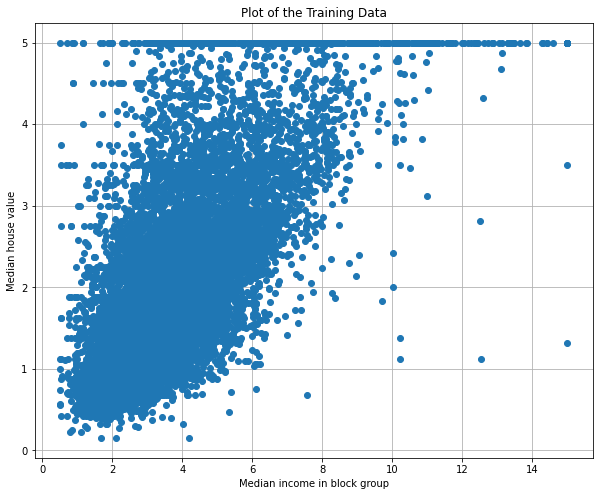

In [5]:
# You can use this function to plot the data and then add your own plots on top..
def plot_data(x, y):
    plt.figure(figsize=[10,8])
    plt.plot(x, y, 'o')
    plt.grid(True)
    plt.xlabel('Median income in block group')
    plt.ylabel('Median house value')

plot_data(x_train_unnormalised, y_train_unnormalised)
plt.title('Plot of the Training Data')

We next normalise the data such that the mean of the data is zero and it is having a specific spread around 0.
This is a good practice, particularly when we are dealing with multiple features, each having a different range of values.

Text(0.5, 1.0, 'Plot of the Training Data After Normalisation')

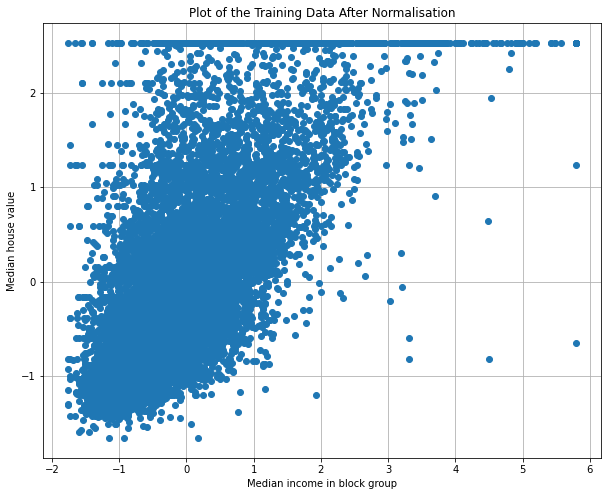

In [6]:
# compute the mean and standard deviation (std) of the attribute
xmean = x_train_unnormalised.mean()
xstd = x_train_unnormalised.std()

# use mean and std to normalise training attribute
x_train = x_train_unnormalised
x_train = (x_train-xmean)/xstd

# use mean and std to normalise testing attribute
x_test = x_test_unnormalised
x_test = (x_test- xmean)/xstd

# compute the mean and standard deviation (std) of the target
ymean = y_train_unnormalised.mean()
ystd = y_train_unnormalised.std()

# use mean and std to normalise training target
y_train = y_train_unnormalised
y_train = (y_train - ymean)/ystd

# use mean and std to normalise testing target
y_test = y_test_unnormalised
y_test = (y_test- ymean)/ystd

# plot the normalised training data
def plot_data(x, y):
    plt.figure(figsize=[10,8])
    plt.plot(x, y, 'o')
    plt.grid(True)
    plt.xlabel('Median income in block group')
    plt.ylabel('Median house value')

plot_data(x_train, y_train)
plt.title('Plot of the Training Data After Normalisation')

## Data Training

Now based on the prepared training data, we employ linear regression to fit a line $y = m * x + b$ to predict the target (median house value) from the attribute (median income).

In [7]:
# initilise the two parameters (m and b) of the linear regression model y = m * x + b
var = tf.Variable(1.) # variable used to update
m = tf.Variable(1., shape=tf.TensorShape(None)) # the parameter equivalent to slope of the line
b = tf.Variable(var) # the parameter equivalent to y-intercept of the line

# return the predicted value from attribute x based on the linear regression model with m and b, i.e., y = m * x + b
def predict(x):
    if len(x.shape)==1:
        x=tf.reshape(x,[x.shape[0],1])
    return tf.reduce_sum(m * x, 1) + b

# the mean squared error (MSE) between the actual target 'y' and the prediected value 'predicted'
def mse(y, predicted):
    return tf.reduce_mean(tf.square(y-predicted))

# optimise m and b based on minimizing MSE loss using gradient descent method 
def update(X, y, learning_rate):
    # compute MSE loss
    with tf.GradientTape(persistent=True) as g:
        loss = mse(y, predict(X))
        
        #print("Loss: ", loss)

    # compute graident based on loss
    dy_dm = g.gradient(loss, m)
    dy_db = g.gradient(loss, b)

    # update m and b along the negative graident controlled by learning rate
    m.assign_sub(learning_rate * dy_dm)
    b.assign_sub(learning_rate * dy_db)

# training process
def train(X, y, learning_rate=0.01, epochs=5):
    X = X.astype(np.float32)
    if len(X.shape)==1:
        X=tf.reshape(X,[X.shape[0],1])

    m.assign([var]*X.shape[-1])
    for i in range(epochs):
        #print("Epoch: ", i)
        update(X, y, learning_rate)



train(x_train, y_train, learning_rate=0.1, epochs=50)


## Data Testing and Linear Model Visualisation

Finally, based on the linear regression result, we analyse and visualise the house value prediction model by computing the predicting error and ploting the result using the test data.

In [8]:
# predict house value using the fitted model y = m * x + b on the test set
x_test = x_test.astype(np.float32)
pred = predict(x_test)
# de-normalise the predicted value
pred *= ystd
pred += ymean

In [9]:
# de-normalise the actual house value on the test set
y_test = y_test*ystd
y_test += ymean
# compute the mean squared error
error = mse(pred,y_test)
print(error)

tf.Tensor(0.6813539, shape=(), dtype=float32)


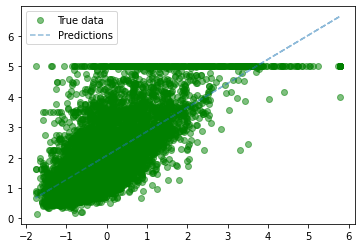

In [10]:
# plot the test data and the linear model y = m * x + b
plt.clf()
plt.plot(x_test, y_test, 'go', label='True data', alpha=0.5)
plt.plot(x_test, pred, '--', label='Predictions', alpha=0.5)
plt.legend(loc='best')
plt.show()
